# CS-6600 Assignment #4 - Binary Classification

**YOUR NAME HERE**

*Weber State University*

This assignment is a bit of a right of passage in the machine learning community. It's a binary classification problem based upon a famous historic event - [the sinking of the Titanic](https://en.wikipedia.org/wiki/Titanic).

For reference, the RMS Titanic was a British passenger liner which sank in the North Atlantic Ocean on April 15th, 1912 after striking an iceberg during its maiden voyage from Southampton, England to New York City, United States. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it the deadliest sinking of a single ship up to that time, and it remains the deadliest sinking of an ocean liner or cruise ship.

It was also notable because there were quite a few hours between when the ship struck the iceberg and when it went under, and most of those who survived did so by boarding lifeboats. In other words, there was a (noisy and nonuniform) process that determined who would be on the lifeboats and who would not, and this process mostly determined who survived.

For this assignment, we're going to try to predict who survives based upon known passenger information.

*Note* - Whether a passenger was on a floating door isn't one of the variables.

<center>
  <img src="https://drive.google.com/uc?export=view&id=1Tb7l6nDAQog3imqv24znRQiMcUkm_dUY" alt="Titanic Door">
</center>

The variables we will have are:

|*Variable* |*Description* |*Details* |
|:----|:----|:----|
|survival|Whether the passenger survived|0 = No, 1 = Yes|
|pclass|The passenger class of the ticket|1 = 1st, 2 = 2nd, 3 = 3rd|
|name| First and last name of the passenger||
|sex|The gender of the passenger||
|age|The age of the passenger||
|sibsp|The number of siblings / spouses on the ship with the passenger||
|parch|The number of parents / children on the ship with the passenger||
|ticket|The ticket number||
|fare|The cost of the ticket||
|embarked|The port of embarcation for the passenger|C = Cherbourg, Q = Queenstown, S = Southampton|

Note that we're using a slightly modified and cleaned version of the commonly available Titanic dataset. Before we import the data, we'll first import our favorite libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

And then, we'll grab some more.

In [2]:
import seaborn as sns #Data visualization library based on matplotlib

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Now, let's get the dataset. The code below should let you import if from my (Dylan's) Google Drive.

In [3]:
#Import the Titanic data
url = 'https://drive.google.com/uc?export=download&id=1Oytm0kGCmWsydZrRvCyK_cOE2WfnaVIA'
titanic_col_names = ['PassengerID','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Embarked']
titanic = pd.read_csv(url,header=0,names=titanic_col_names)
titanic.head()

,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,159,0,3,"Smiljanic, Mr. Mile",male,25.0,0,0,315037,8.6625,S
1,344,0,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,S
2,224,0,3,"Nenkoff, Mr. Christo",male,25.0,0,0,349234,7.8958,S
3,532,0,3,"Toufik, Mr. Nakli",male,25.0,0,0,2641,7.2292,C
4,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,S


I'll also import the seaborn data visualization library based on matplotlib, set a couple style parameters, and get rid of some annoying warnings.

In [4]:
import seaborn as sns #Data visualization library based on matplotlib

#Set some style parameters for seaborn
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
#Get rid of some annying warnings
import warnings
warnings.simplefilter(action='ignore')

Have you heard the phrase "women and children first?" Well, it relates to the [code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first) that is supposed to be practiced in a life-threatening situation. Let's see if it's a decent predictor on the Titanic. In particulary, let's look at how survival percentage broke down by gender.

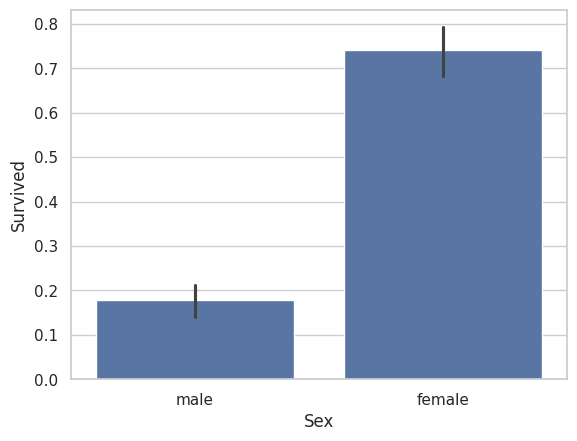

In [5]:
#Examine survival by gender
sns.barplot(x='Sex',y='Survived', data=titanic)
plt.show()

Whoa! Looks like many more men went down with the ship. Now, let's take a look at survival rates based on age, and see how well the "children" aspect of that dictum holds up.

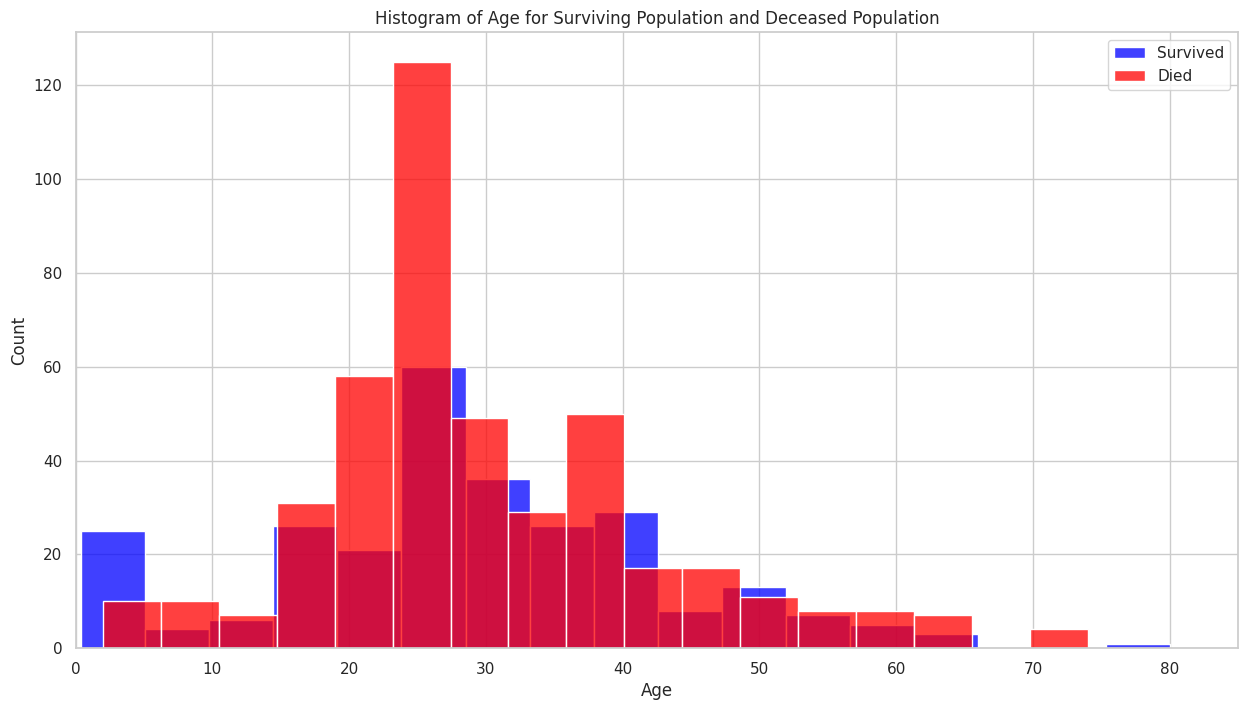

In [6]:
#Survival by age histogram
plt.figure(figsize=(15,8))
sns.histplot(titanic["Age"][titanic.Survived == 1], label='Survived', color='blue', bins=17, kde=False)
sns.histplot(titanic["Age"][titanic.Survived == 0], label='Died', color='red', bins=17, kde=False)
plt.legend(['Survived', 'Died'])
plt.title('Histogram of Age for Surviving Population and Deceased Population')
plt.xlabel('Age')
plt.xlim(0,85)
plt.show()

OK, it looks like being a child did make one more likely to survive as well.

Let's use these two characteristics - age and gender - to build a decision tree predictive model.

First, we're going to want to convert our gender data column into a numeric one. So, we'll create a dummy "male" variable.

In [7]:
#Create a dummy "male" variable
#WARNING - If you run this twice, you'll create two distinct dummy variable columns
gender = pd.get_dummies(titanic["Sex"],drop_first=True)
titanic = pd.concat([titanic,gender], axis='columns')
titanic.head()

,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male
0,159,0,3,"Smiljanic, Mr. Mile",male,25.0,0,0,315037,8.6625,S,True
1,344,0,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,S,True
2,224,0,3,"Nenkoff, Mr. Christo",male,25.0,0,0,349234,7.8958,S,True
3,532,0,3,"Toufik, Mr. Nakli",male,25.0,0,0,2641,7.2292,C,True
4,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,S,False


Then we'll create a dependent and independent variable for the logistic regression model.

In [8]:
#Create the dependent and independent variable for the logistic model
X = titanic[["Age","male"]]
y = titanic["Survived"]

We'll split our data into a training dataset and a test dataset.

In [9]:
#Split the data into training data and test data, 75/25
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .25,random_state = 1912)

Then, we'll build our decision tree predictive model.

In [10]:
#Build the logistic model using the Fare variable
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train);

We can graph visualize this decision tree with the code below.

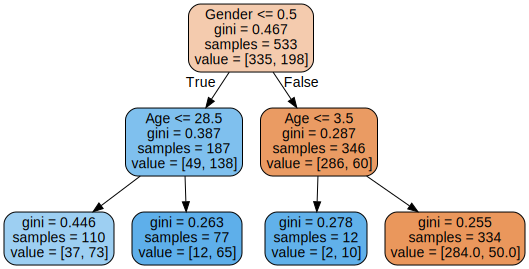

In [11]:
export_graphviz(
        tree_clf,
        out_file=str("titanic_decision_tree.dot"),
        feature_names=["Age", "Gender"],
        rounded=True,
        filled=True
    )
Source.from_file("titanic_decision_tree.dot")

It looks like it first splits on gender, and then on age, but the age split is very different for the men and women.

Now, we'll use this model to predict survival in the test dataset.

In [12]:
#Use the model to predict the y values in the test set.
y_pred = tree_clf.predict(X_test[["Age","male"]])
#Create the confusion matrix
confusion_matrix(y_test,y_pred)

array([[89, 17],
       [18, 54]])

We can check our accuracy, precision, and recall:

In [13]:
#Check the accuracy, precision, and recall
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Precision:",precision_score(y_test,y_pred))
print("Recall:",recall_score(y_test,y_pred))

Accuracy: 0.8033707865168539
Precision: 0.7605633802816901
Recall: 0.75


Grab the probabilities for the ROC curve:

In [14]:
#Get the probabilities for the ROC curve

pred_prob = tree_clf.predict_proba(X_test[["Age","male"]])
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1],pos_label=1)

Finally, graph the ROC curve and get the AUC score:

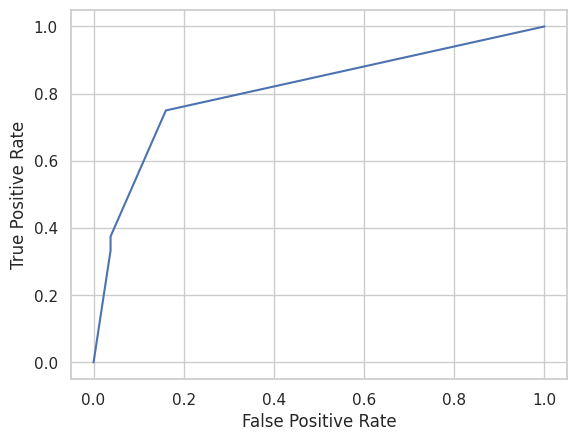

0.8099449685534591

In [15]:
#Graph the ROC curve and display the AUC score
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc_score(y_test,pred_prob[:,1])

An AUC of .81 isn't great, but it's not terrible. For this assignment, you're going to see if you can do better.

The rules are:

- You need to use a logistic regression model.
- You can only use tha data provided in the dataset, and obviously you can't use "survival" (the variable you want to predict) as a predictor.
- You should build your model on the training data produced above, and test it (ROC curve and AUC score) on the test data produced above.

Do some data exploration, try to figure out a good model, and prove the ROC curve and AUC score for the one you find. Please chart the ROC curve and provide the AUC score as above. Full credit will be awarded if you can find an AUC above .8, and a bonus will go to whoever in the class can produce the best model as measured by AUC score on the test dataset.

*Hint* - It helps to be rich.

The assignment is this - do some data exploration and try to figure out a good model. Use random forest as your predictor, and do some data exploration to figure out which variables you want to use, and why.

Once you've got a good model, please chart the ROC curve and provide the AUC score as above.

I'll run your model on a test dataset, with extra credit and glory to whoever gets the highest AUC.

### Notes

*  [The Titanic competition on Kaggle](https://www.kaggle.com/competitions/titanic).
*  [Soundtrack](https://www.youtube.com/watch?v=9bFHsd3o1w0) (Could there by any other option?)



Accuracy: 0.7978
Precision: 0.7273
Recall: 0.7887
ROC AUC: 0.8643


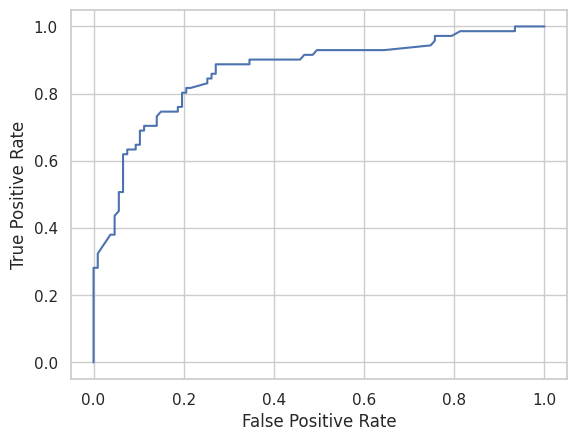

vross calidation AUC scores: [0.91043084 0.8920068  0.89795918 0.82851474 0.91898955 0.88211382
 0.84233449 0.92508711]
Mean cross validation AUC: 0.8872
Standard deviation of CV AUC: 0.0328


In [16]:
#Your work here.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

url = 'https://drive.google.com/uc?export=download&id=1Oytm0kGCmWsydZrRvCyK_cOE2WfnaVIA'
titanic_col_names = ['PassengerID','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Embarked']
titanic = pd.read_csv(url,header=0,names=titanic_col_names)

# Preparing Data
prepData = titanic.drop(["PassengerID", "Name", "Ticket"], axis=1)
prepData["Sex"] = pd.get_dummies(prepData["Sex"], drop_first=True) # Change 0/1 (male/female)


# Make embarked into numerical valuse if Q and S are false, then C is true
embarked_dummies = pd.get_dummies(prepData['Embarked'], drop_first=True) #create embarked dummie set, get rid of the first value (c), and leave the two cloumns q and s
prepData = pd.concat([prepData, embarked_dummies], axis=1)  # move the new embarked columns in the dataset
prepData = prepData.drop(["Embarked"], axis=1) #remove the embarked string

cleanedData = prepData # making seperated dataset of the cleanded data


#Set the output at the start
y = cleanedData["Survived"]

# setting the best labels for the training data. did test on combinatinos of every header and found this was the best one
cleanedData = cleanedData[["Age", "Pclass", "SibSp", "Q"]]
cleanedData["Age_Sex"] = prepData["Age"] * prepData["Sex"]
cleanedData["Age_Q"] = prepData["Age"] * prepData["Q"]
cleanedData["Age_Pclass"] = prepData["Age"] * prepData["Pclass"]
cleanedData["Sex_Pclass"] = prepData["Sex"] * prepData["Pclass"]
cleanedData["Sex_SibSp"] = prepData["Sex"] * prepData["SibSp"]
cleanedData["Sex_Parch"] = prepData["Sex"] * prepData["Parch"]
cleanedData["Sex_Q"] = prepData["Sex"] * prepData["Q"]
cleanedData["Pclass_SibSp"] = prepData["Pclass"] * prepData["SibSp"]
cleanedData["Pclass_Parch"] = prepData["Pclass"] * prepData["Parch"]
cleanedData["Pclass_Q"] = prepData["Pclass"] * prepData["Q"]
cleanedData["SibSp_Q"] = prepData["SibSp"] * prepData["Q"]
cleanedData["SibSp_S"] = prepData["SibSp"] * prepData["S"]
cleanedData["Parch_Q"] = prepData["Parch"] * prepData["Q"]
cleanedData["Parch_S"] = prepData["Parch"] * prepData["S"]


# Set the input (X) and the desired output (Y) Live or not
X = cleanedData

# Seperate the training Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .25,random_state = 23)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


# Set the logisticRegression Machine Learning Method
log_reg = LogisticRegression(max_iter=100, random_state=78, C = 1,  class_weight='balanced', penalty='l1', solver='liblinear')
#The class_weight, penalty and solver are supost to help over fitting the data


# DND Training the data to see roles a 20 or 1 on the titianic
log_reg.fit(X_train, y_train)


# Make predications of values and probabiltity
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]


# Checking the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

fpr, tpr, thresh = roc_curve(y_test, y_prob)

#Graph the ROC curve and display the AUC score
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



# checking corss validation to make sure i am getting good answer and not overfitting
from sklearn.model_selection import cross_val_score

# 8 cross-validation with AUC scoring metric
cv_auc_scores = cross_val_score(log_reg, X_train, y_train, cv=8, scoring='roc_auc')

# Print AUC scores
print(f"vross calidation AUC scores: {cv_auc_scores}")

# Mean AUC
mean_auc_score = np.mean(cv_auc_scores)
print(f"Mean cross validation AUC: {mean_auc_score:.4f}")

# Standard deviation
std_auc_score = np.std(cv_auc_scores)
print(f"Standard deviation of CV AUC: {std_auc_score:.4f}")


#IGNORE EVERYTHING BELOW, Random experiment and unorganized code (Made code text so you can use run all). Everything above is my answer for homework!

Cross-validation AUC scores: [0.91043084 0.8920068  0.89795918 0.82851474 0.91898955 0.88211382
 0.84233449 0.92508711]
Mean cross-validation AUC: 0.8872
Standard deviation of CV AUC: 0.0328


## Feature Importance Comparison for Different `n_estimators`

| Feature  | Importance (`n_estimators = 10000`) | Importance (`n_estimators = 500`) |
|----------|-------------------------------------|-----------------------------------|
| Pclass   | 0.0889                              | 0.0892                            |
| Sex      | 0.2683                              | 0.2737                            |
| Age      | 0.2534                              | 0.2491                            |
| SibSp    | 0.0453                              | 0.0457                            |
| Parch    | 0.0420                              | 0.0422                            |
| Fare     | 0.2652                              | 0.2623                            |
| Q        | 0.0119                              | 0.0125                            |
| S        | 0.0251                              | 0.0253                            |


##Image of distrubition of the data. after adding "class_weight='balanced', penalty='l1', solver='liblinear" to the linearRegrssionModel

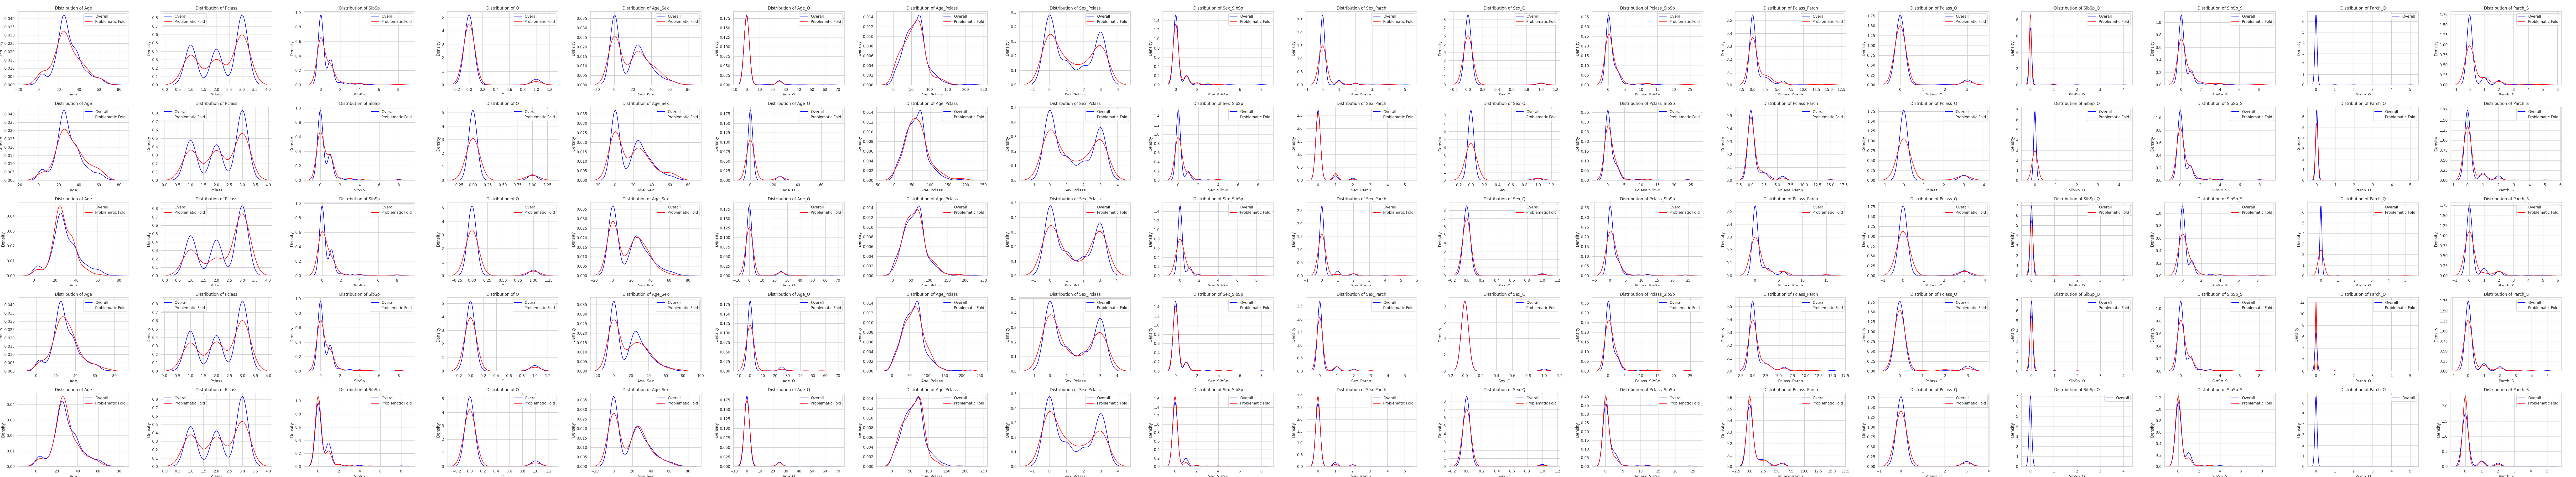



import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Create a folder to save the images
save_dir = "feature_distributions_2"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Use StratifiedKFold to preserve class distribution
cv = StratifiedKFold(n_splits=5)

# Initialize an empty list to store AUC scores and indices
fold_aucs = []
fold_data_indices = []

# Perform manual cross-validation to store results and indices
for train_idx, test_idx in cv.split(X_train, y_train):
    # Train on the training set of this fold
    log_reg.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    
    # Predict probabilities on the test set of this fold
    y_prob = log_reg.predict_proba(X_train.iloc[test_idx])[:, 1]
    
    # Calculate AUC for this fold
    auc_score = roc_auc_score(y_train.iloc[test_idx], y_prob)
    fold_aucs.append(auc_score)
    
    # Store indices for later analysis
    fold_data_indices.append(test_idx)

# Check which fold has the lowest AUC
min_auc = min(fold_aucs)
min_auc_index = fold_aucs.index(min_auc)

print(f"Fold with lowest AUC: {min_auc} (Fold #{min_auc_index})")

for i in range (0,5):
# Get the data from the problematic fold
  problematic_fold_idx = fold_data_indices[i]
  X_fold = X_train.iloc[problematic_fold_idx]

  # Visualize feature distributions and save the plots
  for col in X_fold.columns:
      plt.figure(figsize=(6, 4))
      sns.kdeplot(X_train[col], label='Overall', color='blue')  # Overall feature distribution
      sns.kdeplot(X_fold[col], label='Problematic Fold', color='red')  # Problematic fold feature distribution
      plt.title(f'Distribution of {col}')
      plt.legend()
      
      # Save the figure to the folder with the column name
      plt.savefig(os.path.join(save_dir, f'FoldNumber{i}__{col}_distribution_v2.png'))
      
      # Show the plot (optional, you can remove this if you don't want to display each plot)
      plt.show()


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Different levels of regularization
    'penalty': ['l1', 'l2'],  # L1 and L2 regularization
    'solver': ['liblinear', 'saga'],  # Suitable solvers for L1 and L2
    'max_iter': [100, 200]  # Try different maximum iteration values
}

# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=440)

# Perform Grid Search with 5-fold Cross-Validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate performance of the best model
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with best parameters: {accuracy:.4f}")


cv_scores = cross_val_score(grid_search, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier

cleanData = titanic.drop(["PassengerID", "Name", "Ticket"], axis=1)

cleanData["Sex"] = pd.get_dummies(titanic["Sex"], drop_first=True) # Change 0/1 (male/female)

embarked_dummies = pd.get_dummies(titanic['Embarked'], drop_first=True) #create embarked dummie set, get rid of the first value (c), and leave the two cloumns q and s
cleanData = pd.concat([cleanData, embarked_dummies], axis=1)  # move the new embarked columns in the dataset
cleanData = cleanData.drop(["Embarked"], axis=1) #remove the embarked string

#print(cleanData.head(5))
#cleanData.info()
X = cleanData.drop(["Survived"], axis=1)
y = cleanData["Survived"]
#X.info()
#y.info()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .25,random_state = 1912)




rnd_clf_tan = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf_tan.fit(X_train, y_train)
for score, name in zip(rnd_clf_tan.feature_importances_, X_train.columns):
  print(round(score, 2), name)

# Build the logistic model using the Fare variable
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

X = cleanData.drop(['Survived'], axis=1)
y = cleanData["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .25,random_state = 1912)

log_reg = LogisticRegression(max_iter=100, random_state=42)  # You can adjust max_iter based on your data
log_reg.fit(X_train, y_train)

# Step 6: Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 8: Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# (Optional) Get the probabilities for further analysis (e.g., for ROC curve)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Step 9: Coefficients for interpretation
coefficients = pd.DataFrame(log_reg.coef_.flatten(), X.columns, columns=['Coefficient'])
print("\nCoefficients:")
print(coefficients)

#HyperParamter Tuning Stuff
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [8],
    'min_samples_leaf': [1],
    'max_features': ['auto', 'sqrt', 'log2']
  }

rf_model = RandomForestClassifier(random_state=42)

#randomized Search Cv
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

#Print the best hyperparameters found
print("Best Hyperparameters:" + str(random_search.best_params_))


best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: " + str(accuracy))


{'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Test Accuracy: 0.8314606741573034

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Test Accuracy: 0.8314606741573034

{'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Test Accuracy: 0.8258426966292135


---


{'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9}
Test Accuracy: 0.8258426966292135

'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10

#Test one

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Assuming the cleaned dataset is available as `cleanData`
X = cleanData.drop(['Survived'], axis=1)  # Features
y = cleanData['Survived']  # Target variable


#InterActionData

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1912)



# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=100, random_state=42)


for nFeature in range(1, len(cleanData.columns)):
  print(f"================ {nFeature}==================")
  # RFE Recursive Feature Elimination (remove the least imporant features)
  rfe = RFE(estimator=log_reg, n_features_to_select=nFeature)
  rfe = rfe.fit(X_train, y_train)

# Train the model on the training data
  log_reg.fit(X_train, y_train)
  print("Selected Features:", X_train.columns[rfe.support_])
  print("Feature Ranking:", rfe.ranking_)

  # Make predictions on the test data
  y_pred = rfe.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, rfe.predict_proba(X_test)[:,1])

  # Print results
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"ROC AUC: {roc_auc:.4f}")

  print("\n\n")


from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import itertools


# Automatically create polynomial features
def create_polynomial_features(df):
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    poly_features = poly.fit_transform(df)
    feature_names = poly.get_feature_names_out(df.columns)
    return pd.DataFrame(poly_features, columns=feature_names)

# Use SelectFromModel for feature selection
def select_important_features(model, X, y):
    selector = SelectFromModel(estimator=model).fit(X, y)
    selected_features = X.columns[(selector.get_support())]
    return X[selected_features]

y = cleanData['Survived']


cleanData = cleanData[["Age", "Sex", "Pclass", "Fare", "SibSp","Parch", "Q", "S"]]


# Feature engineering
cleanData = create_polynomial_features(cleanData)

cleanData.info()


# Prepare data
X = cleanData
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1912)

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=100, random_state=42)

# Use Stratified K-Fold Cross Validation for a more stable performance estimate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []


# RFE Recursive Feature Elimination using cross-validation
for nFeature in range(1, len(cleanData.columns)):  # Try with a subset of feature counts
    print(f"Evaluating with {nFeature} features selected...")

    rfe = RFE(estimator=log_reg, n_features_to_select=nFeature)
    rfe.fit(X_train, y_train)

    selected_features = X_train.columns[rfe.support_]

    # Cross-validate the model performance
    roc_auc = cross_val_score(rfe, X_train, y_train, cv=cv, scoring='roc_auc').mean()

    # Evaluate the model on the test data
    y_pred = rfe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Store the results
    results.append({
        'n_features': nFeature,
        'selected_features': list(selected_features),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    })

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results)

results_df.to_csv('results.csv', index=False)

# Display the best performing number of features based on ROC AUC
best_result = results_df.loc[results_df['roc_auc'].idxmax()]
print("\nBest result based on ROC AUC:\n", best_result)
for i in results_df["selected_features"].loc[results_df.index == 40]:
  print(str(i) + "\n")
results_df

13	14
Age,
Sex,
Pclass,
Age_Pclass,
Sex_Pclass,
Age Sex,
Age Pclass,
Sex Pclass,
Sex Age_Sex,
Sex Age_Pclass,
Sex Sex_Pclass,
Pclass Age_Sex,
Pclass Sex_Pclass,
Age_Pclass Sex_Pclass

0.8146067415730337	0.8545454545454545	0.6527777777777778	0.8620828549559894

  
  
  



40	41	Age,Pclass,S,Age_Sex,Age_Pclass,Age_S,Pclass_S,Age Sex,Age Pclass,Age S,Age Sex_Pclass,Age Sex_S,Age Pclass_S,Sex Age_Sex,Sex Age_Pclass,Sex Age_S,Sex Pclass_S,Pclass S,Pclass Age_Sex,Pclass Age_Pclass,Pclass Age_S,Pclass Sex_Pclass,Pclass Sex_S,Pclass Pclass_S,S Age_Sex,S Age_Pclass,S Age_S,S Sex_Pclass,S Pclass_S,Age_Sex Sex_Pclass,Age_Sex Sex_S,Age_Sex Pclass_S,Age_Pclass Sex_Pclass,Age_Pclass Sex_S,Age_Pclass Pclass_S,Age_S Sex_Pclass,Age_S Sex_S,Age_S Pclass_S,Sex_Pclass Sex_S,Sex_Pclass Pclass_S,Sex_S Pclass_S	0.8146067415730337	0.8679245283018868	0.6388888888888888	0.860350172215844  
  

    
      
      Best result based on ROC AUC:
 n_features                                                          17
selected_features    [Age Age_Pclass, Pclass Age_Pclass, Fare Male_...
accuracy                                                      0.808989
precision                                                     0.839286
recall                                                        0.652778
roc_auc                                                       0.853615
Name: 16, dtype: object
['Age Age_Male', 'Age Age_Pclass', 'Age Age_Fare', 'Age Pclass_Fare', 'Age Fare_SibSp', 'Pclass Age_Pclass', 'Fare Age_Pclass', 'Fare Age_Fare', 'Fare Age_SibSp', 'Fare Male_Fare', 'Fare Pclass_Fare', 'Fare Fare_SibSp', 'Fare Fare_Parch', 'Age_Male Age_Pclass', 'Age_Male Age_Fare', 'Age_Male Pclass_Fare', 'Age_Male Fare_SibSp', 'Age_Male Fare_Parch', 'Age_Pclass Age_Fare', 'Age_Pclass Male_Pclass', 'Age_Pclass Male_Fare', 'Age_Pclass Pclass_Fare', 'Age_Pclass Fare_SibSp', 'Age_Pclass Fare_Parch', 'Age_Fare Age_SibSp', 'Age_Fare Male_Pclass', 'Age_Fare Male_SibSp', 'Age_Fare Male_Parch', 'Age_Fare Pclass_SibSp', 'Age_Fare Pclass_Parch', 'Age_Fare SibSp_Parch', 'Age_SibSp Age_Parch', 'Age_SibSp Male_Fare', 'Age_SibSp Pclass_Fare', 'Age_Parch Male_Fare', 'Age_Parch Pclass_Fare', 'Age_Parch Fare_Parch', 'Male_Fare Fare_SibSp', 'Male_Fare Fare_Parch', 'Pclass_Fare Fare_SibSp', 'Pclass_SibSp Fare_SibSp']



from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a pipeline that includes feature selection and a logistic regression model
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),  # Use ANOVA F-value for feature selection
    ('logistic_regression', LogisticRegression(max_iter=100, random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [3, 4, 5, 6, 7],  # Try selecting the top 5, 7, or 10 features
    'logistic_regression__C': [0.969, 0.968,  .972],  # Regularization parameter
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

import shutil
from google.colab import files

# The path to the folder you want to download (replace with your folder path)
folder_path = 'feature_distributions_2'

# Create a zip file of the folder
shutil.make_archive('feature_distributions_2', 'zip', folder_path)

# Download the zip file
files.download('feature_distributions_2.zip')
